In [1]:
# to allow relative imports
import os
from sys_path_util import append_sys_path
append_sys_path()

from lib.experiments.utils.data_repo_api import DataRepoAPI

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from urllib.request import urlopen
import pickle
import datetime

from lib.configuration import DATA_REPO_URL_RAW

In [2]:
# https://censusreporter.org/profiles/05000US09009-new-haven-county-ct/
POPULATION = 854757

covid = DataRepoAPI.get_csv('covid_by_county.csv')
covid.head()

,Date updated,County code,County,Total cases,Confirmed cases,Probable cases,Total case rate,Hospitalized cases,Total deaths,Confirmed deaths,Probable deaths
0,06/02/2020,1,Fairfield,"15,789","15,087",702,"1,673",134,"1,289",998,291.0
1,06/02/2020,2,Hartford,"10,593","9,914",679,"1,187",92,"1,259",958,301.0
2,06/02/2020,3,Litchfield,"1,404","1,338",66,775,5,133,113,20.0
3,06/02/2020,4,Middlesex,"1,161","1,104",57,714,16,152,118,34.0
4,06/02/2020,5,New Haven,"11,548","11,161",387,"1,347",150,990,843,147.0


In [3]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2960 entries, 0 to 2959
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date updated        2960 non-null   object 
 1   County code         2960 non-null   int64  
 2   County              2960 non-null   object 
 3   Total cases         2960 non-null   object 
 4   Confirmed cases     2416 non-null   object 
 5   Probable cases      2416 non-null   object 
 6   Total case rate     2696 non-null   object 
 7   Hospitalized cases  2960 non-null   int64  
 8   Total deaths        2960 non-null   object 
 9   Confirmed deaths    2416 non-null   object 
 10  Probable deaths     2416 non-null   float64
dtypes: float64(1), int64(2), object(8)
memory usage: 254.5+ KB


In [4]:
# transform dates
covid['Date updated'] = pd.to_datetime(covid['Date updated'], format="%m/%d/%Y")
covid = covid.sort_values('Date updated').reset_index(drop=True)

col_transform = {
    'Total cases': 'float32',
    'Confirmed cases': 'float32',
    'Probable cases': 'float32',
    'Total case rate': 'float32',
    'Hospitalized cases': 'float32',
    'Total deaths': 'float32',
    'Confirmed deaths': 'float32',
    'Probable deaths': 'float32',
}

for c in col_transform:
    covid[c] = covid[c].apply(lambda x: x.replace(',', '') if type(x) == str else x, 1)

covid.replace('NaN', np.NaN, inplace=True)
    
# transform numbers
covid = covid.astype(col_transform)

# filter new haven county (code = 5)
new_haven_covid = covid[covid["County code"] == 5].copy()
new_haven_covid.reset_index(drop=True, inplace=True)

new_haven_covid.head()

,Date updated,County code,County,Total cases,Confirmed cases,Probable cases,Total case rate,Hospitalized cases,Total deaths,Confirmed deaths,Probable deaths
0,2020-03-24,5,New Haven,89.0,NaN,NaN,NaN,19.0,0.0,NaN,NaN
1,2020-03-25,5,New Haven,127.0,NaN,NaN,NaN,28.0,2.0,NaN,NaN
2,2020-03-26,5,New Haven,156.0,NaN,NaN,NaN,34.0,2.0,NaN,NaN
3,2020-03-27,5,New Haven,222.0,NaN,NaN,NaN,46.0,6.0,NaN,NaN
4,2020-03-28,5,New Haven,236.0,NaN,NaN,NaN,50.0,6.0,NaN,NaN


In [5]:
start_date = new_haven_covid.loc[0, 'Date updated'].date()
new_haven_covid['Date updated'] = new_haven_covid['Date updated'].apply(lambda x: (x.date() - start_date).days)

In [6]:
new_haven_covid.head()

,Date updated,County code,County,Total cases,Confirmed cases,Probable cases,Total case rate,Hospitalized cases,Total deaths,Confirmed deaths,Probable deaths
0,0,5,New Haven,89.0,NaN,NaN,NaN,19.0,0.0,NaN,NaN
1,1,5,New Haven,127.0,NaN,NaN,NaN,28.0,2.0,NaN,NaN
2,2,5,New Haven,156.0,NaN,NaN,NaN,34.0,2.0,NaN,NaN
3,3,5,New Haven,222.0,NaN,NaN,NaN,46.0,6.0,NaN,NaN
4,4,5,New Haven,236.0,NaN,NaN,NaN,50.0,6.0,NaN,NaN


In [7]:
first_val = new_haven_covid.loc[0, 'Total cases']
new_cases = new_haven_covid['Total cases'].diff().fillna(first_val).values.tolist()

new_haven_covid['New cases'] = [x / POPULATION for x in new_cases]

first200 = new_haven_covid.loc[new_haven_covid['Date updated'] <= 150, :].copy()

<AxesSubplot:xlabel='Date updated'>

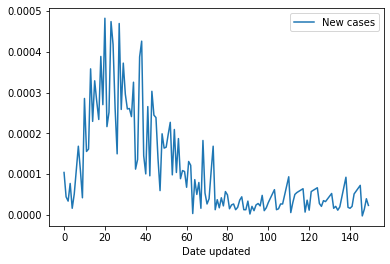

In [8]:
first200.plot(x='Date updated', y='New cases')

## Modelled

In [9]:
def get_df(name):
    url = DATA_REPO_URL_RAW + '/validation/' + name + '.pkl'

    with urlopen(url) as f:
        df = pickle.load(f)

    return df


def df_group_mean(df):
    grouped = df.groupby(['time', 'compartment']).mean()
    grouped.reset_index(inplace=True)
    return grouped


def get_wide(name, max_time):
    
    # get
    df = get_df(name)
    
    # transform
    df = df[df.time <= max_time]
    grouped = df_group_mean(df)
    wide = grouped.pivot(index=['time'], columns=['compartment'], values='value')
    wide.reset_index(inplace=True)
    
    # calc new cases
    first_val = (-1) * (wide.loc[0, 'E'] + wide.loc[0, 'I'])
    new_cases = (wide['S'].diff().fillna(first_val) * (-1)).values.tolist()
    wide['New cases'] = new_cases
    
    return wide
    

def make_ts(name, max_time):
    wide = get_wide(name, max_time)
    x = wide['time'].values.tolist()
    y = (wide['New cases'].pct_change().fillna(0) + 1).values.cumprod()
    return x, y

## Comparison

In [10]:
x1, y1 = make_ts('seir_distanced_post_validation', 150)

x2 = first200['Date updated'].values.tolist()
y2 = (first200['New cases'].pct_change().fillna(0) + 1).values.cumprod()

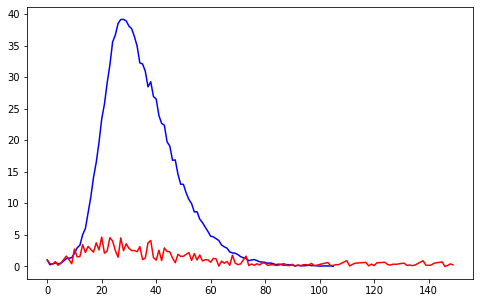

In [11]:
plt.figure(num = 3, figsize=(8, 5))
plt.plot(x1, y1, color='blue')
plt.plot(x2, y2, color='red')
plt.show()